In [1]:
import torch
import numpy as np
import os
from torch import nn
import sys
import polars as pl
import sklearn
import shap
from functools import partial
import pandas as pd
import random
from matplotlib import pyplot as plt
import time
from rdkit.Chem import DataStructs
from tqdm import tqdm
from joblib import Parallel, delayed
import math
sys.path.append('../')

In [2]:
def analyze(root_dir, class_idxs = [0, 1, 2]):
    agg_df = pd.DataFrame()
    for class_idx in class_idxs:
        print(f'\n\n\n------------------- ANALYZING CLASS {class_idx} ----------------------\n\n\n')
        cur_dir = os.path.join(root_dir, str(class_idx), 'importance')
        paths = [os.path.join(cur_dir, name) for name in \
                 sorted(os.listdir(cur_dir), key = lambda x: int(x.split('.')[0]))]
        df = pd.DataFrame()
        for i, path in enumerate(paths):
            _df = pd.read_csv(path)
            _df['feature_idx'] = _df['feature'].apply(lambda x: int(x.split('_')[-1]))
            _df = _df.sort_values(by = 'feature_idx').reset_index(drop = True)
        #     if i == 38:
        #         display(_df)
        #         break
            if 'feature' not in df.columns:
                df['feature'] = _df['feature']
                df['feature_idx'] = _df['feature_idx']
            df[f'fold_{i}'] = _df['importance']
        
        if 'feature' not in agg_df.columns:
            agg_df['feature'] = df['feature']
            agg_df['feature_idx'] = df['feature_idx']
        imp_cols = [f'fold_{i}' for i in range(40)]
        df['mean'] = df.loc[:, imp_cols].mean(axis = 1)
        df['median'] = df.loc[:, imp_cols].median(axis = 1)
        df['std'] = df.loc[:, imp_cols].std(axis = 1)
        
        src_cols = ['mean', 'median', 'std'] + imp_cols
        dst_cols = [f'{class_idx}_{col}' for col in src_cols]
        agg_df[dst_cols] = df[src_cols]
        
        df = df[df['mean'] > 0].reset_index(drop = True)
        print('Describe:')
        display(df.describe())

        print('MEDIAN')
        df['median'].hist(bins = 50)
        plt.show()
        print('MEAN')
        df['mean'].hist(bins = 50)
        plt.show()
        print('STD')
        df['std'].hist(bins = 50)
        plt.show()

        df = df.sort_values(by = 'median', ascending=False).reset_index(drop = True)
        df

        print('HEAD 50')
        plt.figure(figsize=(14, 6))
        plt.boxplot(df.loc[:50, imp_cols].to_numpy().T)
        plt.show()

        print('TAIL 50:')
        plt.figure(figsize=(14, 6))
        plt.boxplot(df.tail(50)[imp_cols].to_numpy().T)
        plt.show()
    
    agg_imp_cols = [col for col in agg_df.columns if '_fold_' in col]
    agg_df['mean'] = agg_df[agg_imp_cols].mean(axis = 1)
    agg_df['median'] = agg_df[agg_imp_cols].median(axis = 1)
    agg_df['std'] = agg_df[agg_imp_cols].std(axis = 1)
#     agg_df = agg_df[agg_df['mean'] > 0].reset_index(drop = True)

    return agg_df





------------------- ANALYZING CLASS 0 ----------------------



Describe:


,feature_idx,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,...,fold_33,fold_34,fold_35,fold_36,fold_37,fold_38,fold_39,mean,median,std
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,998.796837,0.106422,0.102962,0.171917,0.139811,0.125745,0.105700,0.106469,0.085084,0.083670,...,0.110731,0.130091,0.103699,0.125540,0.092317,0.099637,0.090663,0.103206,0.084109,0.076218
std,581.701112,0.100374,0.100485,0.190757,0.159226,0.135799,0.104561,0.103145,0.080490,0.078019,...,0.105914,0.133320,0.103398,0.126074,0.091012,0.094881,0.083695,0.059985,0.055275,0.050968
min,0.000000,0.000780,0.000349,0.000129,0.000278,0.000558,0.000067,0.000132,0.000186,0.000237,...,0.000415,0.000988,0.001406,0.001633,0.000085,0.000138,0.000268,0.000995,0.000412,0.001107
25%,513.250000,0.035779,0.035068,0.050955,0.046118,0.041720,0.035543,0.038339,0.031626,0.030074,...,0.039365,0.042172,0.036935,0.038551,0.033396,0.035438,0.032729,0.059740,0.046017,0.042819
50%,991.000000,0.072456,0.071934,0.110657,0.096701,0.086166,0.073393,0.075393,0.059655,0.058243,...,0.078802,0.085605,0.072218,0.085843,0.065391,0.070374,0.062802,0.088699,0.069052,0.064789
75%,1501.250000,0.145606,0.136188,0.232836,0.179599,0.161760,0.138597,0.138599,0.116330,0.114604,...,0.143654,0.178720,0.138098,0.170774,0.122374,0.129754,0.119146,0.135209,0.107769,0.096363
max,2044.000000,0.577056,0.951435,1.793436,2.438469,1.702015,0.868439,1.035672,0.674595,0.462261,...,0.793314,1.470075,0.938318,1.029572,0.891368,0.668304,0.541983,0.379942,0.360926,0.511945


MEDIAN


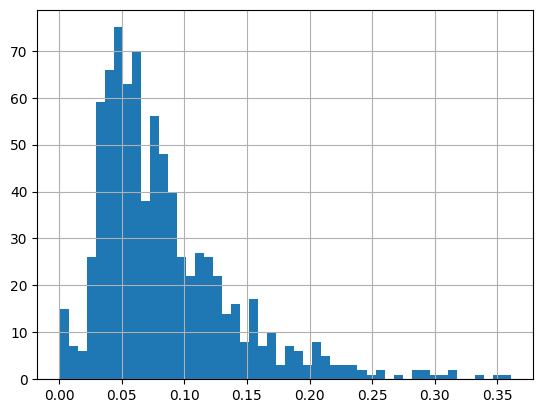

MEAN


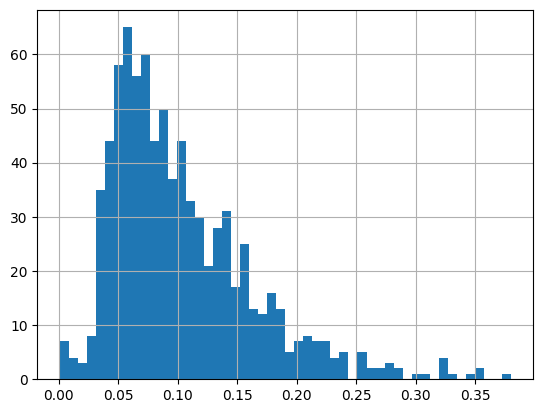

STD


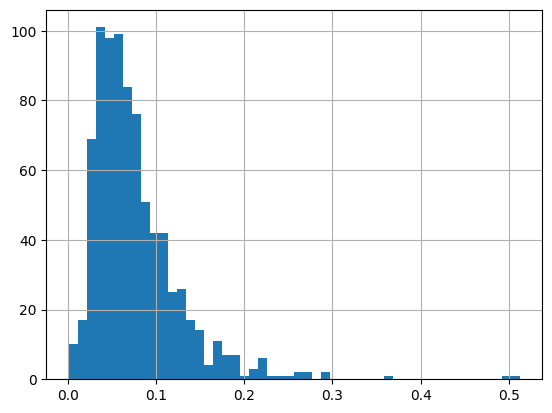

HEAD 50


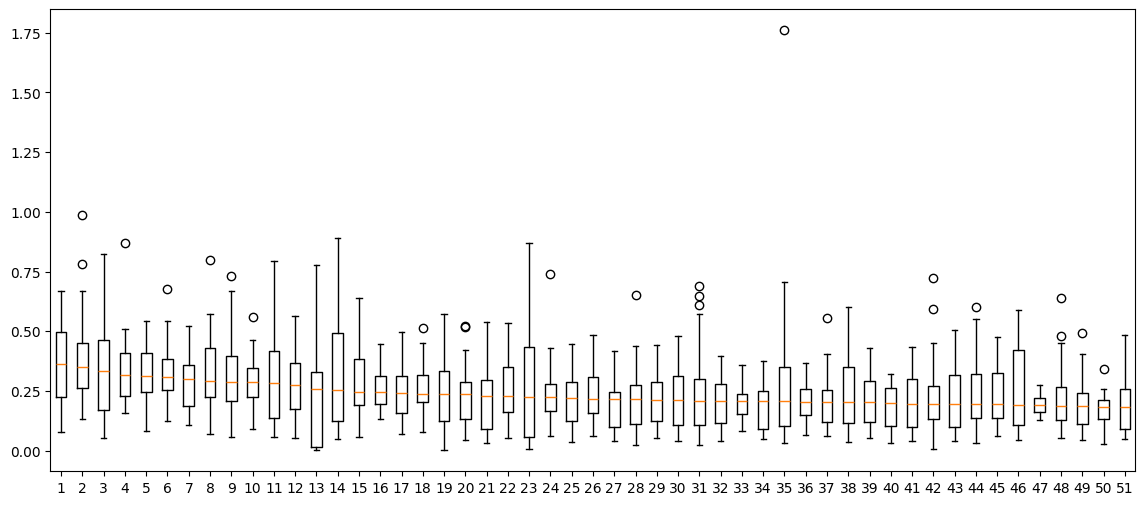

TAIL 50:


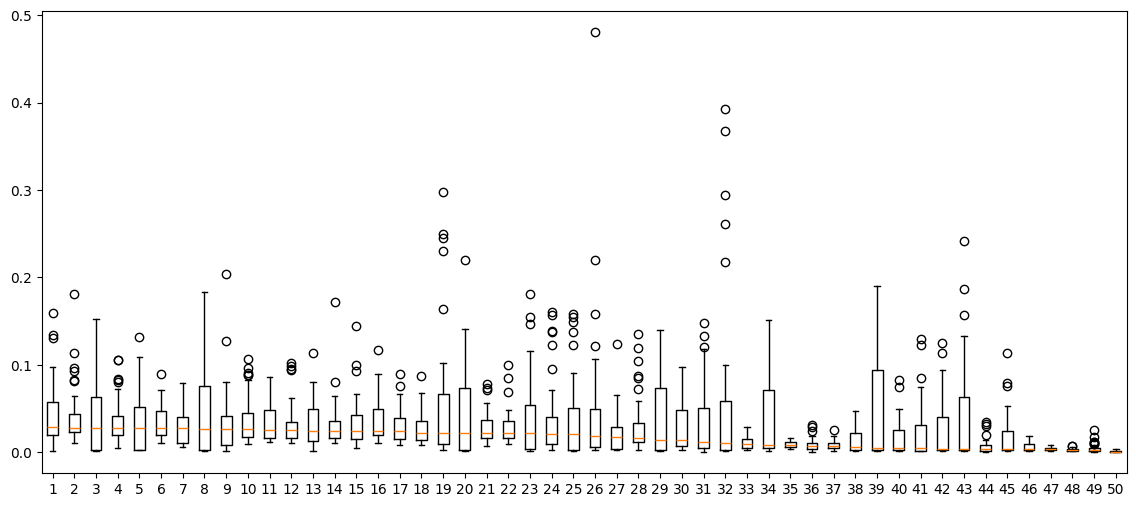




------------------- ANALYZING CLASS 1 ----------------------



Describe:


,feature_idx,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,...,fold_33,fold_34,fold_35,fold_36,fold_37,fold_38,fold_39,mean,median,std
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,998.796837,0.089606,0.072536,0.124558,0.102604,0.097566,0.065086,0.070589,0.062455,0.064203,...,0.070308,0.096022,0.079763,0.092296,0.054285,0.050181,0.049155,0.071963,0.057619,0.053611
std,581.701112,0.086228,0.064999,0.130798,0.123932,0.116450,0.065003,0.070071,0.056602,0.062049,...,0.061964,0.094580,0.077429,0.102334,0.048751,0.045806,0.042651,0.041475,0.036892,0.036200
min,0.000000,0.000225,0.000209,0.000091,0.000151,0.000847,0.000040,0.000028,0.000203,0.000557,...,0.000747,0.001038,0.000931,0.000300,0.000018,0.000025,0.000217,0.000698,0.000340,0.000635
25%,513.250000,0.033470,0.027011,0.038423,0.033375,0.029599,0.023637,0.025010,0.024369,0.023473,...,0.025722,0.033855,0.027048,0.029522,0.020382,0.018791,0.021700,0.043774,0.033681,0.031685
50%,991.000000,0.064347,0.053374,0.083649,0.067715,0.064886,0.047537,0.049097,0.045221,0.046986,...,0.052496,0.067547,0.057134,0.059807,0.040311,0.035695,0.035628,0.063268,0.049044,0.046483
75%,1501.250000,0.117657,0.100884,0.170006,0.137466,0.133468,0.082154,0.092079,0.083732,0.085375,...,0.095849,0.125196,0.110662,0.121193,0.073215,0.066172,0.062002,0.089062,0.071432,0.066848
max,2044.000000,0.763905,0.495223,1.358515,2.100858,1.790956,0.658033,0.756247,0.486834,0.612301,...,0.444260,0.730250,0.808711,1.218994,0.382864,0.301705,0.281752,0.372297,0.294924,0.468151


MEDIAN


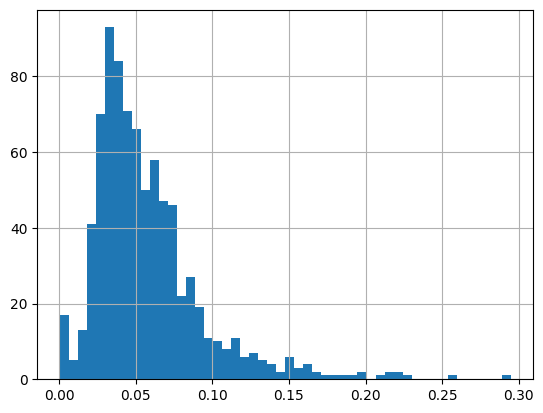

MEAN


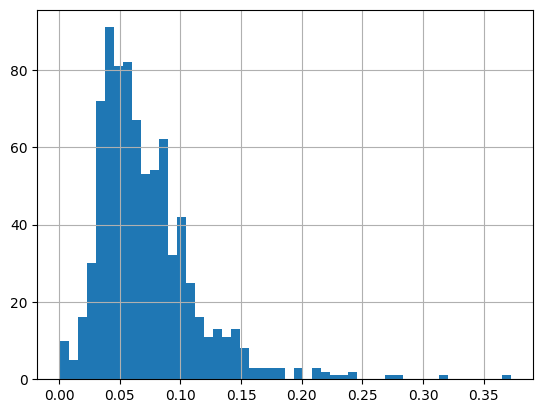

STD


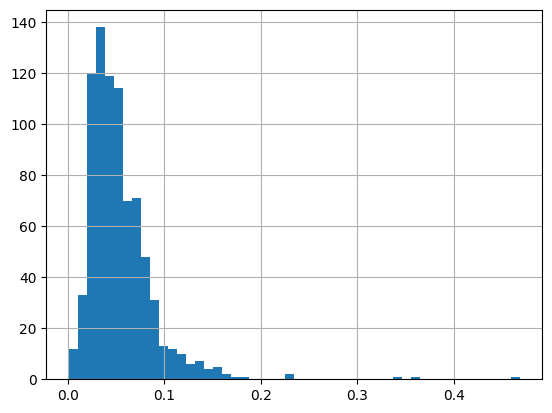

HEAD 50


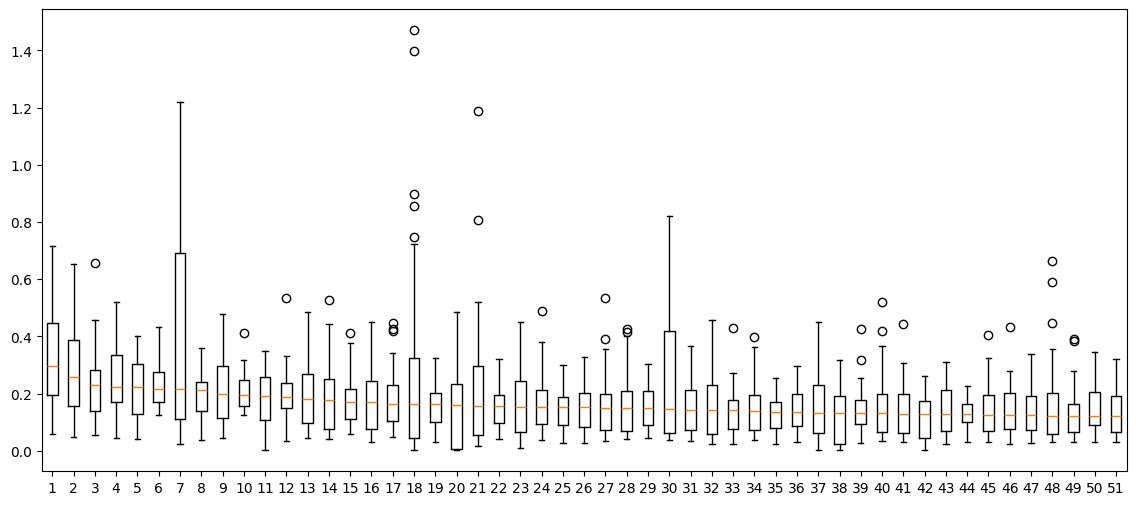

TAIL 50:


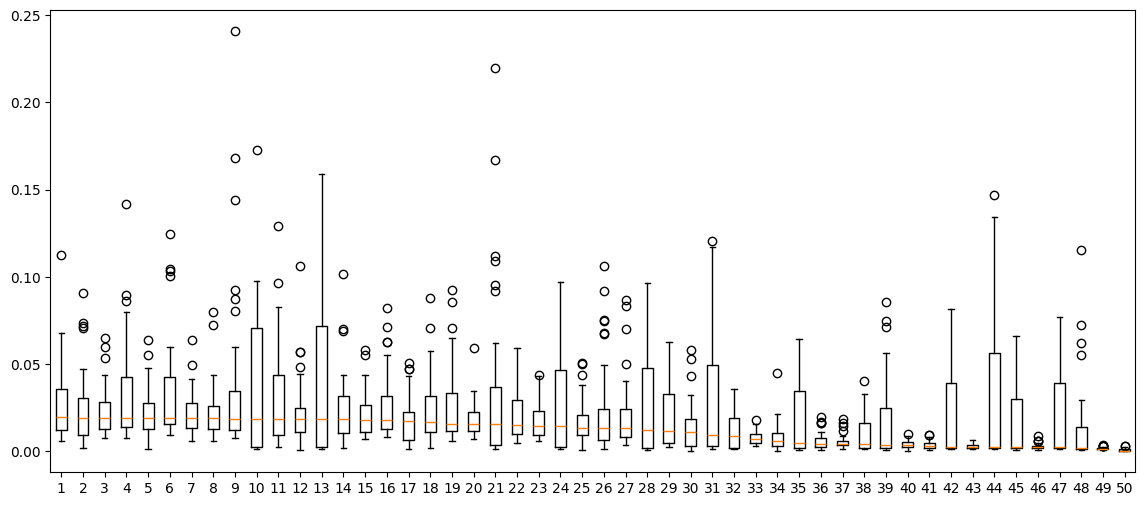




------------------- ANALYZING CLASS 2 ----------------------



Describe:


/tmp/ipykernel_72361/2100316639.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df[dst_cols] = df[src_cols]
/tmp/ipykernel_72361/2100316639.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df[dst_cols] = df[src_cols]
/tmp/ipykernel_72361/2100316639.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

,feature_idx,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,...,fold_33,fold_34,fold_35,fold_36,fold_37,fold_38,fold_39,mean,median,std
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,998.796837,0.150277,0.157375,0.219675,0.187591,0.175125,0.138426,0.143831,0.104589,0.113255,...,0.172698,0.222662,0.184474,0.179066,0.142450,0.127754,0.120912,0.145280,0.116868,0.108980
std,581.701112,0.147822,0.150329,0.227557,0.213400,0.189889,0.139448,0.157680,0.096596,0.106510,...,0.170162,0.226974,0.191051,0.189096,0.135795,0.125774,0.114530,0.084688,0.074377,0.069980
min,0.000000,0.000562,0.000125,0.000372,0.000193,0.001059,0.000028,0.000027,0.000772,0.001805,...,0.000905,0.001498,0.001731,0.000584,0.000025,0.000052,0.000818,0.001363,0.001199,0.001173
25%,513.250000,0.051280,0.054323,0.067471,0.057593,0.052090,0.047525,0.050009,0.038437,0.043070,...,0.059999,0.071418,0.059630,0.054621,0.047488,0.046583,0.042399,0.087933,0.068190,0.065878
50%,991.000000,0.102893,0.109533,0.154627,0.124387,0.121740,0.095265,0.101815,0.074397,0.080460,...,0.124569,0.161077,0.131687,0.123991,0.102112,0.087731,0.085118,0.126280,0.100146,0.094021
75%,1501.250000,0.200874,0.216252,0.295702,0.245526,0.227540,0.186557,0.176429,0.137311,0.149370,...,0.237352,0.296861,0.246668,0.249056,0.191738,0.168764,0.163011,0.185624,0.148823,0.133290
max,2044.000000,1.063401,1.017958,1.875190,2.370158,1.981101,1.059710,2.165179,0.599166,0.948755,...,1.658852,2.025885,1.855143,2.273218,1.023958,1.086115,0.856779,0.839728,0.726911,0.683220


MEDIAN


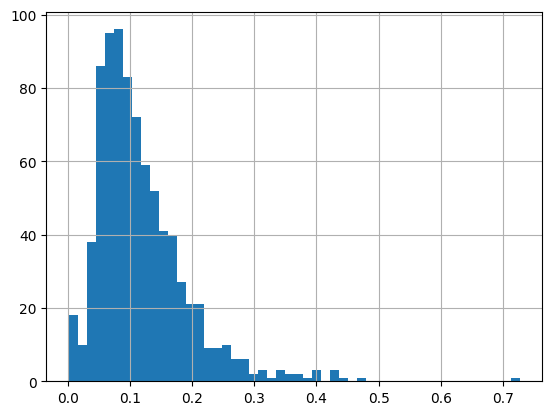

MEAN


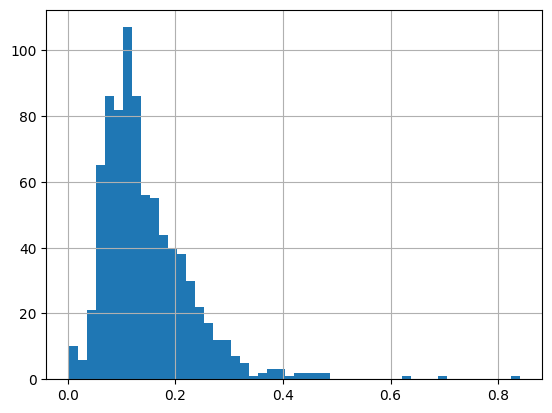

STD


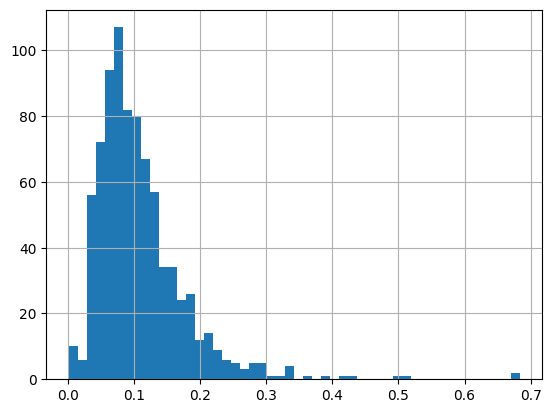

HEAD 50


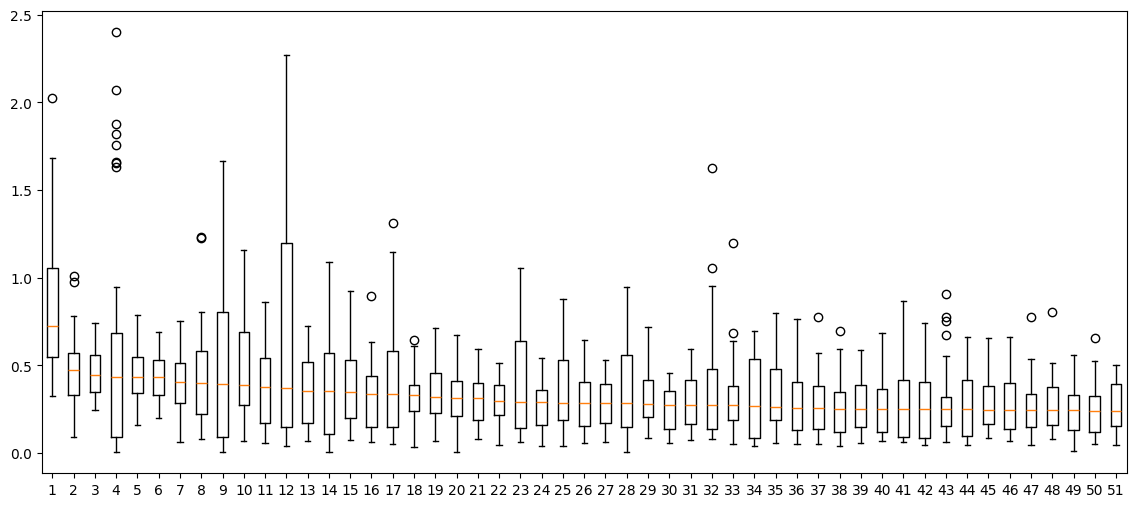

TAIL 50:


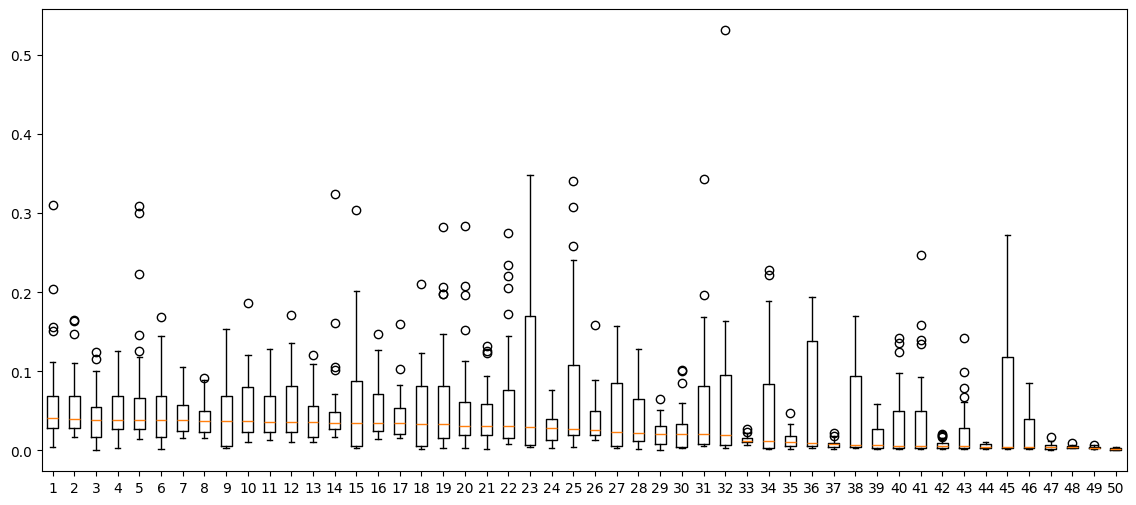

/tmp/ipykernel_72361/2100316639.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df['mean'] = agg_df[agg_imp_cols].mean(axis = 1)
/tmp/ipykernel_72361/2100316639.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df['median'] = agg_df[agg_imp_cols].median(axis = 1)
/tmp/ipykernel_72361/2100316639.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [3]:
agg_df = analyze('/home/dangnh36/datasets/competitions/leash_belka/processed/feature_importance/public_nonshare-mlp-ecfp6-bb_grid-scaffold_5_8_2_3_shuffle_5.8M')

In [4]:
agg_df

,feature,feature_idx,0_mean,0_median,0_std,0_fold_0,0_fold_1,0_fold_2,0_fold_3,0_fold_4,...,2_fold_33,2_fold_34,2_fold_35,2_fold_36,2_fold_37,2_fold_38,2_fold_39,mean,median,std
0,ECFP6_0,0,0.047843,0.041841,0.032992,0.055749,0.035475,0.054628,0.029877,0.042835,...,0.106757,0.186323,0.025397,0.069117,0.202295,0.076494,0.036838,0.052839,0.042860,0.040926
1,ECFP6_1,1,0.227100,0.236531,0.118912,0.044031,0.064620,0.146357,0.262465,0.290696,...,0.095168,0.095175,0.085762,0.414971,0.580890,0.280859,0.173382,0.203748,0.195437,0.117258
2,ECFP6_2,2,0.066890,0.061880,0.036605,0.085020,0.095874,0.148377,0.020818,0.028586,...,0.086019,0.061597,0.020811,0.025434,0.052439,0.045587,0.066414,0.073219,0.062115,0.054743
3,ECFP6_3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ECFP6_4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,ECFP6_2043,2043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2044,ECFP6_2044,2044,0.157763,0.082073,0.219058,0.062193,0.065426,0.025752,0.105866,0.763900,...,0.254678,0.589406,0.346195,0.921542,0.480275,0.126466,0.085933,0.154772,0.081410,0.196313
2045,ECFP6_2045,2045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2046,ECFP6_2046,2046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
agg_df = agg_df[agg_df['mean'] > 0].reset_index(drop = True)
agg_df

,feature,feature_idx,0_mean,0_median,0_std,0_fold_0,0_fold_1,0_fold_2,0_fold_3,0_fold_4,...,2_fold_33,2_fold_34,2_fold_35,2_fold_36,2_fold_37,2_fold_38,2_fold_39,mean,median,std
0,ECFP6_0,0,0.047843,0.041841,0.032992,0.055749,0.035475,0.054628,0.029877,0.042835,...,0.106757,0.186323,0.025397,0.069117,0.202295,0.076494,0.036838,0.052839,0.042860,0.040926
1,ECFP6_1,1,0.227100,0.236531,0.118912,0.044031,0.064620,0.146357,0.262465,0.290696,...,0.095168,0.095175,0.085762,0.414971,0.580890,0.280859,0.173382,0.203748,0.195437,0.117258
2,ECFP6_2,2,0.066890,0.061880,0.036605,0.085020,0.095874,0.148377,0.020818,0.028586,...,0.086019,0.061597,0.020811,0.025434,0.052439,0.045587,0.066414,0.073219,0.062115,0.054743
3,ECFP6_5,5,0.089975,0.073808,0.087602,0.074743,0.046094,0.422493,0.090827,0.134379,...,0.216288,0.230122,0.167865,0.168373,0.075933,0.107455,0.180984,0.116800,0.090540,0.098239
4,ECFP6_8,8,0.113811,0.097199,0.074099,0.234090,0.175206,0.138135,0.140334,0.052467,...,0.057156,0.154646,0.257117,0.149045,0.195628,0.180996,0.091011,0.113545,0.095706,0.069824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,ECFP6_2033,2033,0.051661,0.029427,0.048817,0.067291,0.091856,0.023800,0.016053,0.015424,...,0.089150,0.121006,0.117155,0.169820,0.021028,0.068437,0.073884,0.052895,0.036550,0.045854
818,ECFP6_2034,2034,0.178759,0.171594,0.126273,0.037721,0.022026,0.178819,0.250229,0.112250,...,0.354135,0.108896,0.367198,0.533859,0.770716,0.694619,0.205735,0.198540,0.162904,0.159497
819,ECFP6_2035,2035,0.092318,0.079552,0.067270,0.020040,0.019319,0.128404,0.030586,0.101405,...,0.023283,0.075465,0.053219,0.307566,0.345681,0.451805,0.194400,0.103038,0.073984,0.090357
820,ECFP6_2037,2037,0.146384,0.132639,0.085771,0.083952,0.042330,0.147316,0.207441,0.094835,...,0.095417,0.273067,0.111259,0.307673,0.431010,0.498384,0.059830,0.178414,0.145813,0.124429


In [6]:
for class_idx in [0, 1, 2]:
    print(f'\n\n\n-----{class_idx}-----')
    print(agg_df.sort_values(f'{class_idx}_mean', ascending=False)['feature_idx'].to_list())

print('\n\n\nALL:')
print(agg_df.sort_values('mean', ascending=False)['feature_idx'].to_list())




-----0-----
[255, 1114, 405, 413, 1097, 843, 2004, 191, 1416, 1957, 1209, 1961, 1336, 438, 728, 1027, 690, 1812, 765, 1127, 1375, 977, 1665, 578, 993, 1330, 1985, 1563, 1057, 1166, 1333, 1550, 1031, 1650, 223, 1686, 1, 675, 377, 1430, 1225, 1296, 621, 573, 1385, 544, 969, 352, 1603, 680, 1754, 1524, 935, 1821, 227, 1557, 172, 1260, 33, 146, 1104, 491, 1055, 1607, 486, 1998, 926, 1910, 1832, 1568, 1586, 1088, 1697, 1147, 1602, 656, 1824, 376, 884, 1417, 1135, 1452, 695, 248, 1013, 537, 61, 1391, 2034, 87, 1584, 1083, 149, 1424, 167, 80, 561, 568, 770, 864, 1349, 1159, 655, 862, 492, 721, 1095, 1099, 552, 1306, 447, 1199, 623, 637, 787, 311, 1989, 1474, 1708, 216, 1495, 703, 1071, 713, 162, 2044, 572, 736, 1933, 1784, 117, 1263, 72, 329, 877, 771, 640, 1030, 124, 1045, 1423, 1158, 364, 53, 1145, 198, 1211, 708, 484, 91, 295, 1876, 1461, 1367, 925, 426, 300, 1522, 1144, 354, 2037, 974, 816, 1561, 1513, 1012, 489, 1718, 366, 667, 806, 702, 1722, 261, 1601, 165, 542, 1816, 21, 810, 1342,